In [32]:
import pyarrow.parquet as pa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from category_encoders import BinaryEncoder
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.cm as cm
import os
from typing import Tuple, Union, Callable

In [ ]:
import torch
import torch.nn as nn

class PCAAutoencoder(nn.Module):
    def __init__(self, encoder: nn.ModuleList, decoder: nn.ModuleList, last_hidden_shape):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.last_hidden_shape = last_hidden_shape
        self.bottleneck = nn.ModuleList([nn.Linear(in_features=self.last_hidden_shape, out_features=1),
                                         nn.BatchNorm1d(num_features=1, affine=False)])

    def increase_latentdim(self):
        # Create new bottleneck expansion layer
        new_bottleneck = nn.ModuleList([nn.Linear(in_features=self.last_hidden_shape, out_features=self.bottleneck[0].out_features + 1),
                                        nn.BatchNorm1d(num_features=self.bottleneck[0].out_features + 1, affine=False)])
        # Copying weights while freezing old neurons
        with torch.no_grad():
            new_bottleneck[0].weight[: self.bottleneck[0].out_features] = self.bottleneck[0].weight
            new_bottleneck[0].bias[: self.bottleneck[0].out_features] = self.bottleneck[0].bias

        self.bottleneck = new_bottleneck  # Replace the layer
        self.bottleneck[0].requires_grad_(True)  # Allow gradients

        # Freeze the old neurons using a hook
        self.bottleneck[0].weight.register_hook(self._freeze_old_neurons_hook)
        self.bottleneck[0].bias.register_hook(self._freeze_old_neurons_hook)

        # Turn off gradients for all layers in the encoder (just in case)
        for layer in self.encoder:
            for param in layer.parameters():
                param.requires_grad = False

        self._recreate_decoder()

    def _freeze_old_neurons_hook(self, grad):
        """Backward hook: Freeze gradients for old neurons, allowing updates only for new ones"""
        grad[: -1] = 0  # Zero out gradients for old neurons
        return grad

    def _recreate_decoder(self):
        # Copying old decoder to new
        new_decoder = nn.ModuleList()
        for i, layer in enumerate(self.decoder):
            if i == 0 and isinstance(layer, nn.Linear):
                new_layer = nn.Linear(layer.in_features + 1, layer.out_features)
                nn.init.xavier_uniform_(new_layer.weight)
                if new_layer.bias is not None:
                    nn.init.zeros_(new_layer.bias)
                new_decoder.append(new_layer)
            else:
                new_decoder.append(layer)
        
        self.decoder = new_decoder  # Ensure it's still a ModuleList

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.encoder:
            x = layer(x)
        for layer in self.bottleneck:
            x = layer(x)
        return x

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.decoder:
            x = layer(x)
        return x  # Return the output

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        enc = self.encode(x)
        out = self.decode(enc)
        return out, enc

In [21]:
class PCAAE_Loss(nn.Module):
    def __init__(self, loss_func, lambda_cov=0.01):
        super().__init__()
        self.loss_func = loss_func
        self.lambda_cov = lambda_cov

    
    def forward(self, y_hat, y, z):
        recon_loss = self.loss_func(y_hat, y)

        batch_size, latent_dim = z.shape
        z_mean = torch.mean(z, dim=0, keepdim=True)
        z_centered = z - z_mean

        covariance_matrix = (z_centered.T @ z_centered) / batch_size
        covariance_loss = torch.sum(covariance_matrix**2) - torch.sum(torch.diagonal(covariance_matrix)**2)

        total_loss = recon_loss + self.lambda_cov * covariance_loss
        return total_loss, recon_loss, covariance_loss

In [ ]:
def train_model(model: PCAAutoencoder, goal_hidden_dim: int, optimizer: torch.optim.Optimizer, loss_func: Union[nn.Module, Callable], 
                epochs: int, trainloader: DataLoader, testloader: DataLoader, print_every: int) -> dict:
    writer = SummaryWriter()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    outer_steps = 0
    total_steps = 0
    total_epochs = 0
    total_train_losses, total_test_losses = [], []
    if isinstance(loss_func, PCAAE_Loss):
        total_train_recon_losses, total_test_recon_losses = [], []
        total_train_cov_losses, total_test_cov_losses = [], []
    hidden_dim = 1
    
    while hidden_dim != goal_hidden_dim:
        if not outer_steps == 0:
            # Increasing latent space
            # Reloading best weight before increasing the latent dim
            model.load_state_dict(torch.load(f"model_checkpoints/PCAAE_hidden_dim{hidden_dim}.pt"))
            model.increase_latentdim()
            hidden_dim += 1
            model.to(device)

        outer_steps += 1
        print(f"Training with hidden dim: {hidden_dim}")
        steps = 0
        train_losses, test_losses = [], []
        if isinstance(loss_func, PCAAE_Loss):
            train_recon_losses, test_recon_losses = [], []
            train_cov_losses, test_cov_losses = [], []
        min_test_loss = np.Inf
        min_test_recon_loss = np.Inf

        # Training loop
        for e in range(epochs):
            total_epochs += 1
            running_loss = 0
            # Only for printing it
            running_loss_ = 0
            if isinstance(loss_func, PCAAE_Loss):
                running_recon_loss = 0
                running_cov_loss = 0
                running_recon_loss_ = 0
                running_cov_loss_ = 0

            for X, y in trainloader:
                steps += 1
                total_steps += 1
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                y_hat, hidden = model(X)
                if isinstance(loss_func, PCAAE_Loss):
                    loss, recon_loss, cov_loss = loss_func(y_hat, y, hidden)
                    running_recon_loss += recon_loss.item()*X.size(0)
                    running_cov_loss += cov_loss.item()*X.size(0)
                    running_recon_loss_ += recon_loss.item()
                    running_cov_loss_ += cov_loss.item()
                else:
                    loss = loss_func(y_hat, y)

                loss.backward()
                optimizer.step()
                running_loss += loss.item()*X.size(0)
                running_loss_ += loss.item()

                if steps % print_every == 0:
                    writer.add_scalar("Loss x steps/train", running_loss_/print_every, total_steps)
                    if isinstance(loss_func, PCAAE_Loss):
                        print(f"Epoch: {e + 1}/{epochs}, Step {steps}, Train loss: {running_loss_/print_every:.3f} " 
                              f"Train reconstruction loss: {running_recon_loss_/print_every:.3f} "
                              f"Train covariance loss: {running_cov_loss_/print_every:.3f}")
                        writer.add_scalar("Reconstruction loss x steps/train", running_recon_loss_/print_every, total_steps)
                        writer.add_scalar("Covariance loss x steps/train", running_cov_loss_/print_every, total_steps)
                    else:
                        print(f"Epoch: {e + 1}/{epochs}, Step {steps}, Train loss: {running_loss_/print_every:.3f}")

                    running_loss_ = 0

                    if isinstance(loss_func, PCAAE_Loss):
                        running_recon_loss_ = 0
                        running_cov_loss_ = 0

            # Running model on the test data  
            else:
                running_testloss = 0
                if isinstance(loss_func, PCAAE_Loss):
                    running_test_recon_loss = 0
                    running_test_cov_loss = 0

                with torch.no_grad():
                    model.eval()
                    for X, y in testloader:
                        X, y = X.to(device), y.to(device)
                        y_hat, hidden = model(X)
                        if isinstance(loss_func, PCAAE_Loss):
                            test_loss, test_recon_loss, test_cov_loss = loss_func(y_hat, y, hidden)
                            running_test_recon_loss += test_recon_loss.item()*X.size(0)
                            running_test_cov_loss += test_cov_loss.item()*X.size(0)
                        else:
                            loss = loss_func(y_hat, y)
                        running_testloss += test_loss.item()*X.size(0)


                model.train()

                train_losses.append(running_loss/len(trainloader.dataset))
                total_train_losses.append(running_loss/len(trainloader.dataset))
                test_losses.append(running_testloss/len(testloader.dataset))
                total_test_losses.append(running_testloss/len(testloader.dataset))

                if isinstance(loss_func, PCAAE_Loss):
                    train_recon_losses.append(running_recon_loss/len(trainloader.dataset))
                    total_train_recon_losses.append(running_recon_loss/len(trainloader.dataset))
                    train_cov_losses.append(running_cov_loss/len(trainloader.dataset))
                    total_train_cov_losses.append(running_cov_loss/len(trainloader.dataset))
                    test_recon_losses.append(running_test_recon_loss/len(testloader.dataset))
                    total_test_recon_losses.append(running_test_recon_loss/len(testloader.dataset))
                    test_cov_losses.append(running_test_cov_loss/len(testloader.dataset))
                    total_test_cov_losses.append(running_test_cov_loss/len(testloader.dataset))

                # Saving model when test loss improved # TODO: Make this monitor reconstruction loss when PCAAE_Loss is applied
                if isinstance(loss_func, PCAAE_Loss):
                    if test_recon_losses[-1] <= min_test_recon_loss:
                        print('Test reconstruction loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_test_recon_loss, test_recon_losses[-1]))
                else:
                    if test_losses[-1] <= min_test_loss:
                        print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_test_loss, test_losses[-1]))

                    if not os.path.exists("model_checkpoints"):
                        os.mkdir("model_checkpoints")
                    torch.save(model.state_dict(), f"model_checkpoints/PCAAE_hidden_dim{hidden_dim}.pt")
                    min_test_loss = test_losses[-1]
                
                #TODO - Add logging of test losses to the tensorboard session as well
                writer.add_scalar("Loss x epochs/train", running_loss/len(trainloader.dataset), total_epochs)
                writer.add_scalar("Loss x epochs/test", running_testloss/len(testloader.dataset), total_epochs)
                if isinstance(loss_func, PCAAE_Loss):
                    print(f"Epoch {e+1}/{epochs},\nTrain Loss: {running_loss/len(trainloader.dataset):.3f} "
                        f"Train reconstruction loss: {running_recon_loss_/len(trainloader.dataset):.3f} "
                        f"Train covariance loss: {running_cov_loss_/len(trainloader.dataset):.3f}\n"
                        f"Test Loss: {running_testloss/len(testloader.dataset):.3f} "
                        f"Test reconstruction loss: {running_test_recon_loss/len(testloader.dataset):.3f} "
                        f"Test covariance loss: {running_test_cov_loss/len(testloader.dataset):.3f}")
                    writer.add_scalar("Reconstruction loss x epochs/train", running_recon_loss/len(trainloader.dataset), total_epochs)
                    writer.add_scalar("Covariance loss x epochs/train", running_cov_loss/len(trainloader.dataset), total_epochs)
                    writer.add_scalar("Reconstruction loss x epochs/test", running_test_recon_loss/len(trainloader.dataset), total_epochs)
                    writer.add_scalar("Covariance loss x epochs/test", running_test_cov_loss/len(testloader.dataset), total_epochs)    
                else:
                    print(f"Epoch {e+1}/{epochs}\nTrain Loss: {running_loss/len(trainloader.dataset):.3f} "
                          f"Test Loss: {running_testloss/len(testloader.dataset):.3f}")
                

    logs =  {"train_losses": total_train_losses, 
             "train_recon_losses": total_train_recon_losses, 
             "train_cov_losses": total_train_cov_losses, 
             "test_losses": total_test_losses, 
             "test_recon_losses": total_test_recon_losses, 
             "test_cov_losses": total_test_cov_losses, 
             "steps": total_steps}
    
    writer.close()
    return logs           


In [23]:
# Dataset for tabular data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
# Loading data
inputFeature = pd.read_csv('../Data/NIBRS_ND_2021/processed/input.csv', index_col='Unnamed: 0')
# Separating numerical and categorical features
numerical_features=['population','victim_seq_num','age_num_victim','incident_hour','incident_month','incident_day','incident_dayofmonth','incident_weekofyear']
categorical_features = ['resident_status_code','race_desc_victim',
'ethnicity_name_victim','pub_agency_name','offense_name','location_name','weapon_name'
,'injury_name','relationship_name','incident_isweekend']
# Onehot-encoding categorical features
inputFeature_1h = pd.get_dummies(inputFeature, columns=categorical_features)

In [25]:
# Convert object columns to numeric if they represent categories
for column in inputFeature_1h.select_dtypes(include=['object']):
    inputFeature_1h[column] = inputFeature_1h[column].astype('category').cat.codes

# Train-test split
train, test = train_test_split(inputFeature_1h, test_size=0.1, random_state=42)

# Normalizing numerical features
for feature in numerical_features:
  train[feature] = (train[feature] - train[feature].min()) / (train[feature].max() - train[feature].min())
  test[feature] = (test[feature] - test[feature].min()) / (test[feature].max() - test[feature].min())

# Converting data to tensors
X_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))
y_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))

X_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))
y_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))

In [26]:
# Dataloaders
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [27]:
# Define sizes for the layers
layer_sizes = [227, 64, 32]  # Example decreasing sizes for the encoder

# Create the encoder ModuleList
encoder = nn.ModuleList()
for i in range(len(layer_sizes) - 1):
    encoder.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
    encoder.append(nn.ReLU())

# Create the decoder ModuleList (mirror of the encoder)
decoder = nn.ModuleList()
decoder.append(nn.Linear(1, layer_sizes[len(layer_sizes) - 1]))
for i in range(len(layer_sizes) - 1, 0, -1):
    decoder.append(nn.Linear(layer_sizes[i], layer_sizes[i - 1]))
    decoder.append(nn.ReLU())

# Remove the last ReLU from the decoder (optional, depending on use case)
decoder = decoder[:-1]
criterion = PCAAE_Loss(nn.MSELoss())
model = PCAAutoencoder(encoder, decoder, 32)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 25
print_every = 40

In [28]:
#%load_ext tensorboard
#%tensorboard --logdir=runs/ --port=6006
!tensorboard --logdir=runs/ --port=6006 --reload_multifile=true
logs = train_model(model=model, goal_hidden_dim=5, 
                                         optimizer=optimizer, loss_func=criterion, epochs=epochs,
                                         trainloader=trainloader, testloader=testloader, print_every=40)

2025-03-29 15:47:58.137742: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

E0329 15:48:07.012474 24048 program.py:298] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use


Training with hidden dim: 1
Epoch: 1/25, Step 40, Train loss: 0.041 Train reconstruction loss: 0.041 Train covariance loss: 0.000
Epoch: 1/25, Step 80, Train loss: 0.024 Train reconstruction loss: 0.024 Train covariance loss: 0.000
Epoch: 1/25, Step 120, Train loss: 0.023 Train reconstruction loss: 0.023 Train covariance loss: 0.000
Epoch: 1/25, Step 160, Train loss: 0.024 Train reconstruction loss: 0.024 Train covariance loss: 0.000
Epoch: 1/25, Step 200, Train loss: 0.023 Train reconstruction loss: 0.023 Train covariance loss: 0.000
Epoch: 1/25, Step 240, Train loss: 0.023 Train reconstruction loss: 0.023 Train covariance loss: 0.000
Epoch: 1/25, Step 280, Train loss: 0.023 Train reconstruction loss: 0.023 Train covariance loss: 0.000
Epoch: 1/25, Step 320, Train loss: 0.023 Train reconstruction loss: 0.023 Train covariance loss: 0.000
Epoch: 1/25, Step 360, Train loss: 0.023 Train reconstruction loss: 0.023 Train covariance loss: 0.000
Epoch: 1/25, Step 400, Train loss: 0.023 Train 

C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_24636\3067221106.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"model_checkpoints/

Epoch: 1/25, Step 40, Train loss: 0.045 Train reconstruction loss: 0.026 Train covariance loss: 1.874
Epoch: 1/25, Step 80, Train loss: 0.041 Train reconstruction loss: 0.022 Train covariance loss: 1.877
Epoch: 1/25, Step 120, Train loss: 0.040 Train reconstruction loss: 0.021 Train covariance loss: 1.875
Epoch: 1/25, Step 160, Train loss: 0.040 Train reconstruction loss: 0.021 Train covariance loss: 1.876
Epoch: 1/25, Step 200, Train loss: 0.040 Train reconstruction loss: 0.021 Train covariance loss: 1.883
Epoch: 1/25, Step 240, Train loss: 0.040 Train reconstruction loss: 0.021 Train covariance loss: 1.874
Epoch: 1/25, Step 280, Train loss: 0.040 Train reconstruction loss: 0.021 Train covariance loss: 1.876
Epoch: 1/25, Step 320, Train loss: 0.039 Train reconstruction loss: 0.020 Train covariance loss: 1.874
Epoch: 1/25, Step 360, Train loss: 0.039 Train reconstruction loss: 0.020 Train covariance loss: 1.875
Epoch: 1/25, Step 400, Train loss: 0.039 Train reconstruction loss: 0.021 T

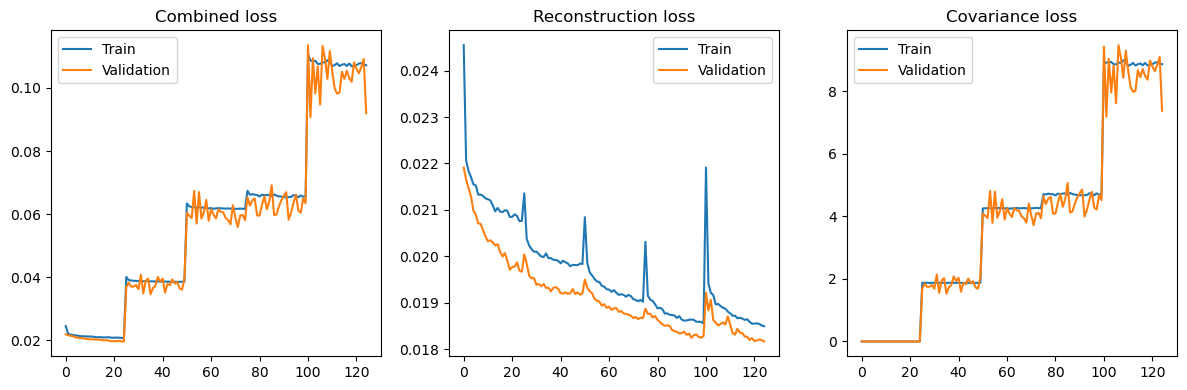

In [29]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(logs["train_losses"], label="Train")
ax[0].plot(logs["test_losses"], label="Validation")
ax[0].set_title("Combined loss")
ax[0].legend()
ax[1].plot(logs["train_recon_losses"], label="Train")
ax[1].plot(logs["test_recon_losses"], label="Validation")
ax[1].set_title("Reconstruction loss")
ax[1].legend()
ax[2].plot(logs["train_cov_losses"], label="Train")
ax[2].plot(logs["test_cov_losses"], label="Validation")
ax[2].set_title("Covariance loss")
ax[2].legend()
plt.tight_layout()
plt.show()

In [30]:
model.encoder

ModuleList(
  (0): Linear(in_features=227, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
)

In [37]:
running_metrics = {"a": 1}
if running_metrics:
    print("yes")

yes
